# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

이 프로젝트에서는 이커머스 웹사이트의 A/B 테스트의 결과를 이해하기 위해 데이터 분석 과정을 진행할 것이다.     
이 노트북을 통해서 회사가 아래 선택지 중 어떤 선택을 해야할지 알아보자. 
- 새로운 웹페이지를 시행, 
- 기존 웹페이지를 유지,
- 결정을 내리기 위해 더 오래 실험을 진행 

<a id='probability'></a>
## Part I - Probability

먼저, 라이브러리를 import 하자. 

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#setting the seed
random.seed(42)

### 1.1
이제 `ab_data.csv` 데이터를 읽어와 `df`에 저장할 것이다. 아래 표는 데이터를 설명한 것으로, 총 5개의 컬럼이 있다. 
 
 
<center>

|컬럼|목적|유효값|
| ------------- |:-------------| -----:|
|user_id|사용자 ID의 고유값|Int64 values|
|timestamp|사용자가 웹페이지를 방문한 시각|-|
|group|이 A/B 테스트에서, 사용자는 두개의 큰 그룹으로 나눠져있다.<br> `control` 그룹 사용자에게는 `old_page`가 보여지고, `treatment` 그룹 사용자에게는 `new_page`가 보여지게 된다. <br>그러나, 원본 데이터에는 `control` 그룹 사용자인데 `new_page` 가 보여지는 등 **일부 부정확한 데이터** 가 존재한다.|`['control', 'treatment']`|
|landing_page|사용자가 방문한 페이지를 나타낸다.|`['old_page', 'new_page']`|
|converted|사용자가 최종적으로 회사의 상품을 구매하였는지 여부를 나타낸다. 여기서, `1`은 그 사용자가 상품을 구매했다는 것을 의미한다.|`[0, 1]`|
</center>

**a.** `ab_data.csv` 파일에서 데이터셋을 읽어와 몇 개의 행을 살펴보자:

In [3]:
# 데이터 읽어오기
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** 데이터셋의 총 행 개수.

In [4]:
# 행개수
df.shape[0]

294478

**c.** 고유한 사용자 수.

In [5]:
# 고유한 사용자 수
df.user_id.nunique()

290584

**d.** 전환한 사용자의 비율.

In [6]:
# 전환한 사용자의 비율
df['converted'].sum() / df.shape[0]

0.11965919355605512

**e.** "group"이 `treatment`인데 "landing_page"가 `new_page`가 아닌 경우.

In [7]:
# "group"이 treatment인데 "landing_page"가 new_page가 아닌 경우의 수
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

1965

In [8]:
# "group"이 control인데 "landing_page"가 old_page가 아닌 경우의 수
df.query('group == "control" and landing_page != "old_page"').shape[0]

1928

In [9]:
# 위의 두 숫자의 합
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group == "control" and landing_page != "old_page"').shape[0] 

3893

**f.** 결측치 확인

In [10]:
# 결측치 확인
df.isnull().sum() # 없음

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### 1.2  
**group** 과 **landing_page** 컬럼은 아래 둘 중 하나의 값을 가져야 한다:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


즉, `control`그룹 사용자는 `old_page`와, `treatment`그룹 사용자는 `new_page`와 매치가 되어야 한다. 

그러나, 몇 개의 행에서 `treatment`그룹인데도 `new_page` 값이 있거나, `control`그룹인데 `old_page` 값이 있는데, 이 경우 우리는 실제 사용자가 어떤 페이지를 받았는지 확신할 수 없다.   

**a.** 부정확한 행들을 삭제하고, 그 결과를 새로운 데이터프레임 **df2**에 저장.

In [11]:
# 부정확한 행들을 삭제하고, 그 결과를 새로운 데이터프레임 df2에 저장.
df2 = df.drop(df[((df['group']=='treatment') & (df['landing_page']=='old_page') | (df['group']=='control') & (df['landing_page']=='new_page'))].index)

In [12]:
# 모든 부정확한 행들이 df2에서 삭제되었는지 재 확인 - 
# 아래 구문의 결과값은 0이어야 함. 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3  
**df2** 와 아래 셀들을 통해 질문에 답해보자.

**a.** **df2**에는 고유한 **user_id**가 몇 개 있는지?

In [13]:
# 고유한 user_id 개수
df2.user_id.nunique()

290584

**b.** **df2**에는 중복된 **user_id**가 1개 있다. 어떤 것인가?

In [14]:
# 중복 user_id 찾기
df2[df2.duplicated(['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

**c.** 중복된 **user_id**? 

In [15]:
# 동일한 user_id를 가진 중복된 행
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** **df2**에서 중복된 **user_id**를 가진 행 중 하나를 삭제한다.

In [16]:
# df2에서 중복된 user_id를 가진 행 중 하나를 삭제한다.
# 주의! 중복된 user_id를 가진 행이 완전히 똑같은 값을 가지고 있는게 아니기 때문에 dataframe.drop_duplicates()는 적용안됨. 
df2 = df2.drop_duplicates(subset="user_id", keep="first")

# 삭제되었는지 재 확인
df2[df2.duplicated(['user_id'])].shape[0]  # 없음

0

###  1.4  
**df2** 와 아래 셀들을 통해 질문에 답해보자.

**a.** 받은 페이지에 관계없이 사용자의 전환율 얼마인가?<br><br>
> 확률은 전체 사용자 중 "전환된" 성공률이며, $p_{population}$ 로 표현된다.



In [17]:
# 전체 사용자의 전환율
df2.converted.mean()

0.11959708724499628

**b.** 사용자가 `control` 그룹이라고 할 때, 전환율은 얼마인가?

In [18]:
# "control" 그룹에서 사용자의 전환율
conv_rate_c = df2[df['group']=='control'].converted.mean()
conv_rate_c

/var/folders/pv/f7xfvbxd1p3470n641kdm7l00000gn/T/ipykernel_17158/2362478500.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conv_rate_c = df2[df['group']=='control'].converted.mean()


0.1203863045004612

**c.** 사용자가  `treatment` 그룹이라고 할 때, 전환율은 얼마인가? 

In [19]:
# "treatment" 그룹에서 사용자의 전환율
conv_rate_t = df2[df['group']=='treatment'].converted.mean()
conv_rate_t

/var/folders/pv/f7xfvbxd1p3470n641kdm7l00000gn/T/ipykernel_17158/1699139085.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conv_rate_t = df2[df['group']=='treatment'].converted.mean()


0.11880806551510564

> 위 (b)와 (c)에서 구한 확률은 전환율로 표현할 수 있다. 

In [20]:
# 실제 두 그룹의 전환율의 차이(obs_diff)를 계산.
obs_diff = conv_rate_t - conv_rate_c
obs_diff

-0.0015782389853555567

**d.** 사용자가 new page를 받을 확률은?

In [21]:
# 사용자가 "new page"를 받을 확률
df2[df2['landing_page']=='new_page'].shape[0] / df2.shape[0]

0.5000619442226688

오래된 페이지를 받은 `control` 그룹과 새로운 페이지를 받은 `treatment` 그룹간의 전환율 차이는 **0.0015**로 매우 **근소한** 차이로 보인다.    
따라서 새로운 페이지를 받은 `treatment` 그룹의 사용자가 더 많은 전환을 했다고 말하기는 어렵다. 

<a id='ab_test'></a>
## Part II - A/B Test

timestamp 는 각 이벤트와 연계되기 때문에, 우리가 이벤트들을 인지할 수 있는 한 우리는 계속해서 가설 검정을 진행할 수 있다. 

그러나, 어려운 문제는: 
- 한 페이지가 다른 페이지보다 유의미하게 더 낫다고 여겨지는 즉시 멈출 것인가? 아니면 이것이 특정 기간동안 계속해서 일어나야 하는가? 
- 어떤 한 페이지가 다른 페이지보다 낫다는 결정을 하기 위해서는 얼마나 오래 실험을 해야하는가? 

이런 질문들은 보통 A/B 테스트를 할 때 고려해야하는 어려운 부분들이다. 


### 2.1
지금은, 단지 주어진 데이터에만 근거해서 결정을 내려야 한다고 가정해보자.   

> 앞서 전환율을 계산했을 때, old page 가 new page보다 전환율이 **근소하게** 높았던 것을 기억해보자 (1.4.c).

만약 제 1종 오류율을 5%로 가정했을 때 new page가 확실히 더 낫지 않은 이상, old page가 new page 보다 더 낫다고 가정하고자 할때,   
귀무가설과 대립가설(**$H_0$** and **$H_1$**)은 각각 어떻게 될까?  

이 가정을 말로 풀어서 또는 용어로 설명하자면, old page와 new page의 "전환" 확률 (혹은 비율) 또는 **$p_{old}$** and **$p_{new}$** 라고 할 수 있다. 

>- **$H_0$** (귀무가설) : **$p_{old}$** 와 **$p_{new}$** 가 동일
>- **$H_1$** (대립가설) : **$p_{new}$** 가 **$p_{old}$** 보다 큼

###  2.2 - 귀무가설 $H_0$ 검정
귀무가설 $H_0$ 하에서, $p_{new}$ 와 $p_{old}$ 는 같다고 가정한다. 또한,  $p_{new}$ 와 $p_{old}$ 는 모두 `df2` 의 **전환율**과 같다고 가정한다. 따라서, 우리의 가정은: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

이 섹션에서는: 

- 두 그룹 모두 샘플링(부트스트랩)을 하여, "전환" 확률 $p$ 를 계산한다. 

- 두 그룹 모두 `df2`의 데이터 개수를 샘플의 크기로 사용한다. 

- 위의 두 그룹의 "전환" 확률의 차이를 계산한다. 

- 두개의 표본 사이의 "전환율 차이"를 10,000번 반복하여 표본분포로 나타내고 예측값을 계산한다. 


**a.** 귀무가설 하에서 $p_{new}$의 **전환율**은 얼마인가?

In [22]:
# "treatment" 그룹의 전환율 -> 귀무가설 하에서 전체 모집단의 전환율
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** 귀무가설 하에서 $p_{old}$의 전환율은 얼마인가?

In [23]:
# "control" 그룹의 전환율 -> 귀무가설 하에서 전체 모집단의 전환율
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** treatment 그룹 사용자의 수$n_{new}$는 얼마인가?

In [24]:
# "treatment" 그룹 사용자 수
n_new = df2[df2['landing_page']=='new_page'].shape[0]
n_new

145310

**d.** control 그룹 사용자의 수 $n_{old}$는 얼마인가?

In [25]:
# "control" 그룹 사용자 수
n_old = df2[df2['landing_page']=='old_page'].shape[0]
n_old

145274

**e. `treatment` 그룹의 무작위 표본 추출**<br> 

귀무가설 하에서, 전환율 $p_{new}$를 가지고 $n_{new}$번 무작위 추출한다. 

귀무가설 하에서, 전환율 $P_{new}$를 가지고 $N_{new}$번 무작위 추출하기 위해서, 우리는 아래 3가지 방법 중 하나를 사용할 수 있다:

- numpy.random.binomial

- numpy.random.choice

- pandas.DataFrame.sample


이 프로젝트에서는, `numpy.random.choice()` 메소드를 사용해 무작위로 $n_{new}$ 개의 값을 생성할 것이다. <br>
그리고 이 $n_{new}$의 1과 0을 `new_page_converted` numpy 배열에 저장할 것이다. 

In [26]:
# treatment 그룹의 무작위 표본 추출
np_new = np.array(df2[df2['landing_page']=='new_page'].converted)
new_page_converted = np.random.choice([0,1], size=n_new, p=[p_new, 1-p_new])
new_page_converted

array([1, 1, 1, ..., 0, 1, 1])

**f. `control` 그룹의 무작위 표본 추출** <br>
귀무가설 하에서, 전환율 $p_{old}$로 $n_{old}$번 무작위 추출한다. <br> 
그리고 이 $n_{old}$의 1과 0 값을 `old_page_converted` 라는 numpy 배열에 담는다. 

In [27]:
# control 그룹의 무작위 표본 추출
np_old = np.array(df2[df2['landing_page']=='old_page'].converted)
old_page_converted = np.random.choice([0,1], size=n_old, p=[p_old, 1-p_old])
old_page_converted

array([0, 1, 1, ..., 1, 1, 1])

**g.** (e)와 (f)에서 구한 무작위 샘플의 "전환율" 평균의 차이를 $(p{'}_{new}$ - $p{'}_{old})$ 구한다.

In [28]:
# 무작위 샘플의 "전환율" 차이
sam_diff = new_page_converted.mean() - old_page_converted.mean()
sam_diff

-0.002138317225620412


**h. 표본 분포** <br>
여기서는 위 (a) 부터 (g)까지 사용했던 무작위 추출 방법을 10,000번 반복하여 `new_page_converted` 와 `old_page_converted`를 다시 생성하고 전환율의 차이 $(p{'}_{new}$ - $p{'}_{old})$ 를 구할 것이다. 

<br>
그리고 모든 전환율 차이 $(p{'}_{new}$ - $p{'}_{old})$ 값을 `p_diffs` 라고 하는 새로운 numpy 배열에 담을 것이다. 

In [29]:
# 표본 분포
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new, 1-p_new])
    old_page_converted = np.random.choice([1,0], size=n_old, p=[p_old, 1-p_old])
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

**i. 히스토그램**<br> 
**p_diffs** 의 히스토그램을 그려보자. 

그리고, `plt.axvline()` 메소드를 이용해 `df2` 데이터에서 관측된 실제 차이를 차트에 표시해볼 것이다. (`obs_diff`를 다시 떠올려보자)

Text(0, 0.5, '추출 데이터 개수')

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54872 missing from c

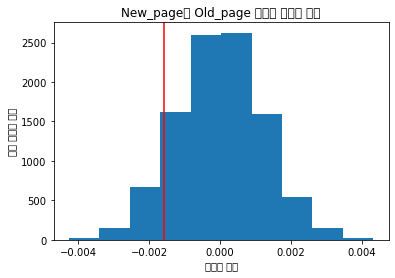

In [30]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red') # df2에서 관측된 실제 차이값
plt.title('New_page와 Old_page 사이의 전환율 차이')
plt.xlabel('전환율 차이')
plt.ylabel('추출 데이터 개수')

**j.** `df2`에서 관측된 실제 차이값보다 더 큰 **p_diffs**의 비율은 얼마인가? 

In [31]:
# obs_diff 보다 큰 p_diffs 비율 
(np.array(p_diffs)>obs_diff).mean()

0.9006

위의 결과에 따라, p-value는 0.9028이라는 것을 알 수 있다. 

위의 히스토그램 차트를 보면, 빨간색 선에서부터 오른쪽 방향으로 많은 데이터가 있는 것을 알 수 있고(대립가설), `obs_diff`보다 큰 `p_diffs` 값이 관측될 확률인 p-value를 계산했을 때, 0.907로 이는 `제 1종 오류`의 유의수준인 0.05보다 큰 값임을 알 수 있다. 그러므로 귀무가설을 기각할 수 없고, 이는 즉 `treatment` 그룹과 `control` 그룹 사이에 전환율의 차이가 없다는 것을 가정한다. 



**l. 가설 검정을 위해 내장함수 사용하기**<br>
내장함수를 이용해서도 비슷한 결과를 얻을 수 있다. 내장함수를 사용하는 것은 코드를 작성하기는 쉽지만, 위에서 다룬 부분은 통계적 유의성에 대해 정확하게 사고하기 위해 중요한 연습이었다는 점을 참고하자. 

- `convert_old`: old_page의 총 전환 횟수
- `convert_new`: new_page의 총 전환 횟수
- `n_old`: old_page가 주어진 사용자 수 
- `n_new`: new_page가 주어진 사용자 수


In [32]:
import statsmodels.api as sm

# old_page의 총 전환 횟수
convert_old = df2.query('landing_page == "old_page"').converted.sum()

# new_page의 총 전환 횟수
convert_new = df2.query('landing_page == "new_page"').converted.sum()

# old_page가 주어진 사용자 수
n_old = df2.query('landing_page == "old_page"').user_id.nunique()

# new_page가 주어진 사용자 수
n_new = df2.query('landing_page == "new_page"').user_id.nunique()

# 확인
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

**m.** 이제 `sm.stats.proportions_ztest()` 를 사용해서 검정 통계와 p-value 값을 계산하자.  
내장함수 사용에 대해 도움을 얻고 싶다면 [여기](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html)를 참고해라. 

문법은 다음과 같다: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```

예시를 보면, 아래와 같다. 
```bash
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative="larger")
```
여기서, 
- `count_array` = 각 그룹의 "전환율"을 나타낸다.
- `nobs_array` = 각 그룹의 총 관측 개수(행수)를 나타낸다.
- `alternative` = `[‘two-sided’, ‘smaller’, ‘larger’]` 중 하나의 값을 선택한다. 차례로 양측검정, 왼쪽 단측검정, 오른쪽 단측검정을 의미한다. 

> 양측검정(Two-tailed) : $H_1$ 은 $(p_{new} = p_{old})$. <br>
> 왼쪽 단측검정(Left-tailed) : $H_1$ 은 $(p_{new} < p_{old})$. <br>
> 오른쪽 단측검정(Right-tailed) : $H_1$ 은 $(p_{new} > p_{old})$. 

위의 내장함수는 z_score와 p_value 값을 리턴한다. 

### 이(2) 표본 Z검정 (독립표본 Z검정)

앞서 10,000번 반복하여 무작위 추출된 두 개의 표본에서 "전환율"의 차이인 `p_diffs`, 즉 $(p{'}_{new}-p{'}_{old})$의 분포를 차트로 나타낸 것을 생각해보자. 

두 개의 독립 정규 분포의 평균을 비교하는 또 다른 방법은 **이(2)표본 Z검정(two-sample z-test)** 이다.   
아래의 식을 사용해서 Z검정을 시행하고 Z_score 를 계산할 수 있다: 

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

여기에서,
- $p{'}$ 는 표본의 "전환율" 
- $p_{new}$ 와 $p_{old}$ 는 모집단의 두 그룹의 "전환율" 
- $\sigma_{new}$ 와 $\sigma_{old}$ 는 모집단의 두 그룹의 표준편차
- $n_{new}$ 와 $n_{old}$ 는 두 개의 그룹 또는 표본(여기서는 동일함)의 크기

를 말한다. 

>Z검정은 표본의 크기가 크고, 모집단의 분산(또는 표준편차)를 알고 있을 때 시행한다. z-score는 표준오차에 대해서 두 개의 "전환율" 사이의 차이를 나타낸다.   
> (표준오차에 대한 정보는 [여기](https://goodtogreate.tistory.com/entry/%ED%91%9C%EC%A4%80%EC%98%A4%EC%B0%A8-Standard-Error#:~:text=%ED%8F%89%EA%B7%A0%EC%9D%98%20%ED%91%9C%EC%A4%80%20%EC%98%A4%EC%B0%A8(%ED%8F%89%EA%B7%A0,%EB%82%B4%EC%9D%98%20%EB%B3%80%EB%8F%99%EC%84%B1%EC%9D%84%20%EC%B8%A1%EC%A0%95%ED%95%A9%EB%8B%88%EB%8B%A4.)에서 확인) 

다음 단계는 아래 두 개의 값을 비교하여 귀무가설을 기각할지 또는 채택할지 결정을 내리는 것이다: 
- $Z_{score}$
- $Z_{\alpha}$ 또는 $Z_{0.05}$, 또는 95%의 신뢰구간에서의 임계값.    
단측 검정에서 $Z_{0.05}$ 는 1.645이며, 양측검정에서는 1.960이다. z-table 에서 직접 $Z_{\alpha}$ 을 결정할 수도 있다. 

먼저, 가설이 양측검정인지, 왼쪽 단측검정인지, 또는 오른쪽 단측검정인지 결정할 필요가 있다. 그것에 따라서, $Z_{score}$과 $Z_{\alpha}$를 비교해 귀무가설을 기각하거나 채택할 것이다. 다른 말로, "기각역"은 $Z_{score}$가 그 영역에 있을 때 귀무가설을 기각하는 구간이다. 

>오른쪽 단측검정의 경우, $Z_{score}$ > $Z_{\alpha}$ 인 경우 귀무가설을 기각한다. <br>
>왼쪽 단측검정의 경우, $Z_{score}$ < $Z_{\alpha}$ 인 경우 귀무가설을 기각한다. 


참고: 
- 이 [페이지](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples)의 예시 9.1.2, courtesy www.stats.libretexts.org

먼저, statsmodels 라이브러리를 import 한다.

In [33]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative="larger")
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


z-score 가 **-1.3109**라는 것은 관측된 차이값(`obs_diff`)이 평균보다 1.31만큼 표준 편차가 낮다는 것을 의미한다. 
일반적으로, 단측 검정에서 $Z_{\alpha}$ 또는 $Z_{0.05}$는 **1.645**이며 지금과 같이 오른쪽 단측 검정의 경우, 𝑍𝑠𝑐𝑜𝑟𝑒  >  𝑍𝛼 이면 귀무가설을 기각할 수 있다. 따라서 여기서는 𝑍𝑠𝑐𝑜𝑟𝑒 **-1.31**이 **1.645** 보다 크지 않다는 점에서, 귀무가설을 기각할 수 없다. 

또한 p-value는 **0.905**로 앞서 구했던 p-value인 **0.907** 과 매우 비슷한 값이다. 결과적으로 귀무가설을 기각할 수 없다. 

<a id='regression'></a>
### Part III - 회귀 분석 방법

###  3.1 
이 마지막 파트에서는, 위의 PartII에서 얻은 A/B 테스트 결과가 회귀 분석 방법을 이용해 동일하게 얻어질 수 있다는 것을 확인할 것이다. <br><br> 

**a.** `df2` 데이터의 각 행이 "전환" 이거나 "전환아님" 둘 중 하나이기 때문에, 여기서는 **회귀분석** 방법을 이용할 것이다. 
예측된 반응변수(여기서는 `converted`)가 0과 1 사이의 확률(여기서는 _전환아님_ 이거나 _전환_)일 때 우리는 회귀 분석 방법을 사용할 수 있다. 

**b.** 여기서 목적은 **statsmodels**  라이브러리를 사용해 사용자가 받은 페이지의 타입에 따라 전환율에 유의미한 차이가 있는지 보기 위해서 **a.**에서 말한 회귀 분석 모델을 fit하는 것이다. 그러나 먼저 아래의 두개의 컬럼을 `df2`에 생성할 필요가 있다: 
 1. `intercept` - 전체 컬럼에서 이 값은 `1`이다. 
 2. `ab_page` - 이것은 dummy 변수 컬럼으로, **treatment** 그룹인 경우 `1`을, 그렇지 않은 경우 `0`을 갖는다. 

In [34]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** **statsmodels** 을 사용하여 위의 (b)에서 생성한 두 개의 컬럼을 넣고 회귀 모델을 실행시키자. 그리고 사용자가 전환했는지 아닌지 예측하기 위해서 모델을 fit 해보자. 

In [35]:
# 회귀 모델을 만들고 fit 해보자. 
logis_model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logis_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** 모델의 summary를 확인해보자.

In [36]:
# Use summary2() method
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-05-30 15:35 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**In Part II**
- **$H_0$** (귀무가설) : **$p_{old}$** 는 **$p_{new}$** 와 같다. 
- **$H_1$** (대립가설) : **$p_{new}$** 는 **$p_{old}$** 보다 크다.    

이 경우, **단측검정** 이다.

**In Part III**.  
- **$H_0$** (귀무가설) : **$p_{old}$** 는 **$p_{new}$** 와 같다. 
- **$H_1$** (대립가설) : **$p_{old}$** 는 **$p_{new}$** 와 같지않다. 

이 경우, **양측검정** 이다.   

또한, 여기서 p-value 값인 **0.1899**는 여전히 제 1종 오류의 유의수준인 **0.05** 보다 크다. 

I refered to the [Reference](https://www.statology.org/null-hypothesis-of-logistic-regression/).   
It says,   

> _"The null hypothesis states that the coefficient(β1) is equal to zero. In other words, there is no statistically significant relationship between the predictor variable, x, and the response variable, y._   
> _The alternative hypothesis states that coefficient(β1) is not equal to zero. In other words, there is a statistically significant relationship between x and y."_

**f.** Now, let's consider other things that might influence whether or not an individual converts.  I will discuss why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into my regression model?

Since it seems that there is no relationship between `converted` and the `group`, we need to consider if there is other things that affects the dependent variable, `converted` along with the `group` variable.   

If their combined effect on the dependent variable, which is `converted`, is ignored then the results that we get can be biased (technically known as omitted variable bias).

However, including too many variables in the model can lead to a problem called Multicollinearity.   
The more variables included in the model, typically, the less independent variation there will be for each of the individual variables. 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, I will also add an effect based on which country a user lives in. 

1. I will need to read in the **countries.csv** dataset and merge together the `df2` datasets on the appropriate rows. We call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, I will consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Then I will create dummy variables for these country columns. 


In [37]:
# Read the countries.csv
df_coun = pd.read_csv('countries.csv')
df_coun.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# Join with the df2 dataframe
df_merged = df2.join(df_coun.set_index('user_id'), on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [39]:
# Create the necessary dummy variables
df_merged = df_merged.join(pd.get_dummies(df_merged['country']))
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [40]:
# Fit the model, and summarize the results
country_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK']])
country_result = country_model.fit()
country_result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-05-30 15:35 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [41]:
# Exponentiate the coefficents from the summary 
np.exp(country_result.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

Looking at all p-values in the summary, all the p-values are **greater** than the _Type I Error rate_ of 0.05.     
So I can conclude that this logistic model is **NOT statistically significant** and there is no relationship between conversion rate and country either.   

With coefficient values above, I can add

- For every unit for UK user, conversion is 1% more likely to happen compared to CA user, holding all other variables constant.    
- For every unit for US user, conversion is 1% more likely to happen compared to CA user, holding all other variables constant.     

But these findings are not practically significant as well.


**h. Fit the model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an **interaction between page and country** to see if there are significant effects on conversion.  

First, I will create the necessary additional columns for interactive dummy variables, and fit the new model.   
These are simply created by multiplying the country and treatment dummy variables - for each country -.    

In [42]:
# Add interactive dummy variables. 
df_merged['US-inter'] = df_merged['US']*df_merged['ab_page']
df_merged['UK-inter'] = df_merged['UK']*df_merged['ab_page']
df_merged['CA-inter'] = df_merged['CA']*df_merged['ab_page']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US-inter,UK-inter,CA-inter
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [43]:
# Fit the model, and summarize the results
country_inter_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK', 'US-inter', 'UK-inter']])
country_inter_results = country_inter_model.fit()
country_inter_results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-05-30 15:35 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US-inter       0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK-inter       0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

In [44]:
# Exponentiate the coefficents from the summary 
np.exp(country_inter_results.params)

intercept    0.134794
ab_page      0.934776
US           1.017682
UK           1.011854
US-inter     1.048001
UK-inter     1.081428
dtype: float64

Looking at all p-values in the summary, all the p-values here are also **greater** than the _Type I Error rate_ of 0.05.**   
So I can conclude that this logistic model is also **NOT statistically significant** and there is no interaction between page and country, and conversion rate and page+country as well.   

With coefficient values above, I can add

- For every unit for UK user + new page, conversion is 1% more likely to happen compared to CA user, holding all other variables constant.    
- For every unit for US user + new page, conversion is 1% more likely to happen compared to CA user, holding all other variables constant.     

But these findings are not practically significant as well.

<a id='conclusions'></a>
## Conclusions

In conclusion, through the sampling distributions and logistic regression models, I could **NOT** find any clues to reject the null hypothesis. 
In all of the analysis in each steps, p-value was greater than the _Type I Error rate_ of 0.05, assuming that the results are likely from the null hypothesis.  

Also, in logistic regression model, I added additional information about `countries` in order to find any relationship with the dependent variable, `converted`. However, there was no evidence that the `countries` data itself and the combined variable `countries` plus `ab_page` were related to the conversion rate.   

So, in conclusion I **failed to reject the null hypothesis.**  

I can say that the **new page is NOT better than the old page**, so it is better to keep the version A instead of B.   

<a id='submission'></a>
### Submission

In [45]:
# convert the notebook to the .html file. 
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'Analyze_ab_test_results_notebook.ipynb' matched no files


255